# Notæ 10

# Funcionalidades avanzadas de CPLEX

## 1. Restricciones lazy

En la actualidad, los solvers de PLE, e.g. CPLEX o GUROBI, proveen mecanismos para manejar bajo demanda algunas de las restricciones de la formulación. Así surge el concepto de **restricciones lazy**, que representan un subconjunto, típicamente grande, del conjunto de restricciones de la formulación, y sin ellas la formulación estaría incompleta (i.e. posiblemente entregue soluciones incorrectas). 

En muchos modelos, puede ser computacionalmente más rápido tratar a algunas restricciones como lazy, en cuyo caso el solver no las incluirá inicialmente, sino que las agregará únicamente cuando estén violadas. 
En general, son útiles en formulaciones que contienen muchas restricciones y muchas de ellas suelen satisfacerse trivialmente.

A diferencia del concepto de desigualdades válidas, las restricciones lazy eliminan soluciones enteras, que de otra forma serían factibles. Es decir, agregar restricciones lazy afectará el conjunto de soluciones factibles enteras.
CPLEX siempre se asegura que *todas* las restricciones lazy estén satisfechas antes de designar un punto entero del poliedro como una nueva solución, de lo contrario agregará las lazy violadas a ese nodo del árbol de B\&B y continuará con la resolución de la relajación lineal.

Existen dos estrategias para manejarlas. A continuación veremos cada una de ellas con más detalle.
1. **Pool de restricciones lazy.**
2. **Callback de restricciones lazy.**

## 1.1. Pool de restricciones lazy

Esta estrategia es la más sencilla ya que el solver es quien se ocupa de incorporar las restricciones lazy cuando estén violadas. Esto se logra generando *todas* las restricciones lazy antes de resolver el modelo, pero en lugar de agregarlas al modelo, se agregan en un **pool de restricciones lazy** (podemos pensarlo como un conjunto). Así, CPLEX verifica que se satisfagan todas las restricciones del pool antes de anunciar el hallazgo de una nueva solución entera. Las restricciones que queremos considerar desde el arranque las incoporamos al modelo con el ya conocido método <code>add_constraint</code>, mientras que las lazy las incorporamos al pool con <code>add_lazy_constraint</code>.

Para ejemplificar esta estrategia seguiremos como caso de estudio el **Problema de Ordenamiento Lineal**. 

**Definición.** Sea $D_n =(V_n,A_n)$ el **digrafo completo** de $n$ nodos, es decir, el grafo dirigido con conjunto de vértices $V = \{0,\ldots,n-1\}$ y la propiedad de que para todo par de nodos distintos $i$ y $j$, hay un arco $(i,j)$ de $i$ a $j$ y un arco $(j,i)$ de $j$ a $i$.

**Definición.** Un **torneo** $T$ en $A_n$ es un subconjunto de arcos que contiene, para todo par de nodos distintos $i$ y $j$, alguno de los arcos $(i,j)$ o $(j,i)$, pero no ambos.

**Definición.** Un **torneo acíclico** es un torneo sin ciclos dirigidos, es decir, que no contiene un conjunto de arcos de la forma $\{(v_1,v_2), (v_2,v_3), \ldots, (v_k,v_1)\}$ para algún entero $k>1$ y nodos distintos $v_1,v_2,\ldots,v_k$.

### &#x1f4bb; Actividad 1

Diseñar las siguientes funciones:

* <code>digrafo_completo</code> que, dado un número natural $n$, retorne el digrafo completo $D_n$.
* <code>es_torneo</code> que, dados un digrafo completo $D$ y una lista de arcos $T$, determine si $T$ es un torneo para $D$.
* <code>es_torneo_aciclico</code> que, dados un digrafo completo $D$ y una lista de arcos $T$, determine si $T$ es un torneo acíclico para $D$. Pueden ser de utilidad las funciones edge_subgraph y find_cycle de <code>NetworkX</code>, las puede investigar.

Recordar escribir casos de prueba para estas funciones.

In [60]:
## Espacio para resolver Actividad 1

def digrafo_completo(n):
    # Completar
    raise Exception("Función no implementada")

def es_torneo(D, T):
    # Completar
    raise Exception("Función no implementada")
    
def es_torneo_aciclico(D, T):
    # Completar
    raise Exception("Función no implementada")

**Resolución de Mauro.**

In [95]:
from docplex.mp.model import Model
import networkx as nx

In [96]:
def digrafo_completo(n):
    graph = nx.complete_graph(n)     # Grafo completo Kn
    return nx.to_directed(graph)     # Digrafo completo Dn

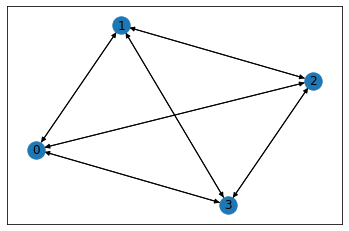

In [97]:
D4 = digrafo_completo(4)
nx.draw_networkx(D4)

In [98]:
def es_torneo(D, T):
    for i in D:
        for j in D:
            if j >= i: # seguimos un orden lexicográfico
                continue
            if (((i,j) not in T and (j,i) not in T) or
               ((i,j) in T and (j,i) in T)):
                return False
    return True

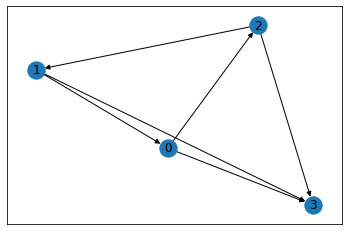

In [99]:
torneo = [(0,2), (0,3), (1,0), (1,3), (2,1), (2,3)]
assert es_torneo(D4, torneo)
nx.draw_networkx(D4.edge_subgraph(torneo))

In [100]:
assert not es_torneo(D4, [(1,2)])
assert not es_torneo(D4, [(0,2), (0,3), (1,0), (1,3), (2,1), (2,3), (3,1)])

In [101]:
def es_torneo_aciclico(D, T):
    if not es_torneo(D,T):
        return False
    try:
        nx.find_cycle(D.edge_subgraph(T))
        return False
    except:
        return True

In [102]:
assert not es_torneo_aciclico(D4, torneo)

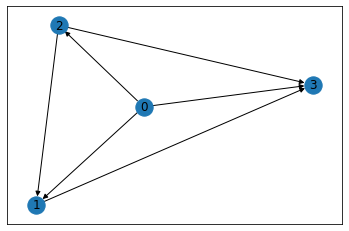

In [103]:
torneo_aciclico = [(0,1), (0,2), (0,3), (1,3), (2,1), (2,3)]
assert es_torneo_aciclico(D4, torneo_aciclico)
nx.draw_networkx(digraph.edge_subgraph(torneo_aciclico))

**Definición.** Un **ordenamiento lineal** de los nodos $\{0,1,\ldots,n-1\}$ es un *ranking* de los nodos dados por una secuencia lineal, o equivalentamente, una permutación de los nodos. Denotamos $\langle v_0, v_1, \ldots v_{n-1} \rangle$ al ordenamiento lineal que rankea primero al nodo $v_0$, segundo a $v_1$, etc., y último a $v_{n-1}$. Si $\sigma$ denota un ordenamiento lineal, entonces $\sigma(i)$ representa la posición del nodo $i$ es este ordenamiento. 

**Observación.** Todo torneo acíclico $T$ en $A_n$ se corresponde con un ordenamiento lineal de los nodos de $V_n$, y viceversa: el nodo rankeado primero es el único que no tiene arcos de entrada en $T$, el nodo rankeado segundo es el único que tiene un arco de entrada en $T$ (proveniente del nodo rankeado primero), etc., y el nodo rankeado último es el único que no tiene arcos de salida en $T$.

Usualmente, las relaciones de orden son ponderadas, y tenemos un peso $c_{ij}$ que representa el beneficio que resulta cuando $i$ es rankeado antes que $j$, o equivalentemente, cuando el arco $(i,j)$ pertenece al torneo acíclico. Luego, el **Problema de Ordenamiento Lineal (LOP, del inglés Linear Ordering Problem)** se define como sigue.

**Problema de Ordenamiento Lineal (LOP)**</br>
**Entrada.** Digrafo completo $D_n = (V_n, A_n)$ con costos de arco $c_{ij}$ para todo $(i,j) \in A_n$.</br>
**Objetivo.** Encontrar un torneo acíclico $T$ en $A_n$ tal que $\sum_{(i,j) \in T} c_{ij}$ es tan grande como sea posible.

Una formulación de PLE para resolver el LOP está motivada por el siguiente lema.

**Lema.** Dados un digrafo completo $D_n = (V_n, A_n)$ y un torneo $T$ en $A_n$, $T$ es un torneo acíclico si y sólo si $T$ no contiene un conjunto de arcos de la forma $\{(v_0,v_1),(v_1,v_2),(v_2,v_0)\}$ con $v_0,v_1,v_2$ nodos distintos en $V_n$, o equivalentemente, el subdigrafo inducido $D_n[T]$ no contiene ciclos dirigidos de largo 3.

Se considera una variable de decisión (binaria) $x_{ij}$ para todo $(i,j) \in A_n$, tal que $x_{ij} = 1$ si y sólo si $i$ precede a $j$ en el orden. Luego, tenemos la siguiente formulación.

\begin{align*}
\text{Maximizar:} ~~~ & \sum_{(i,j) \in \mathcal A_n} c_{ij}x_{ij} \tag{1} \\
\text{Sujeto a:} ~~~ & x_{ij} + x_{ji} = 1 & \forall~i,j \in V_n,~ i < j . \tag{2}\\
& x_{ij} + x_{jk} + x_{ki} \leq 2 & \forall~i,j,k \in V_n,~ i < j,~ i < k,~ j \neq k. \tag{3} \\
& x_{ij} \in \{0,1\} & \forall~i,j \in A_n.
\end{align*}

La función objetivo (1) maximiza el peso total de $T$. Las restricciones (2) aseguran que $i$ precede a $j$ o viceversa, pero no ambas. Las restricciones (3) prohiben ciclos dirigidos de largo 3. Notar que piden $i < j,~ i < k,~ j \neq k$ para evitar escribir múltiples restricciones para un mismo ciclo (cambiando el vértice que se considera como inicial o cambiando el sentido horario u antihorario).

A continuación, se presenta la función <code>construir_modelo_lop</code> que construye este modelo en Python. Esta función toma como argumentos un digrafo completo <code>D</code> y un diccionario <code>C</code> que mapea los arcos con sus pesos. A su vez, usa un diccionario para guardar a las variables <code>X</code>. Esta estrategia de usar un diccionario, aprovechando que se puede indexar por los arcos del digrafo, ya la hemos usado en el notebook 8 para definir a las variables de precedencia en la formulación para el Power Dominating Set Problem. 

In [104]:
def construir_modelo_lop(D, C):
    
    # Inicializamos el modelo   
    modelo = Model(name='LOP')  
    
    # Diccionario de variables
    X = {(i,j): modelo.binary_var("x_" + str(i) + "_" + str(j)) for i,j in D.edges}
    
    # Funcion objetivo (1)
    modelo.maximize(modelo.sum(C[(i,j)] * X[(i,j)] for i,j in D.edges))
    
    # Restricciones
    for i in D:
        for j in D:
            if j >= i:
                continue
            # Restricciones (2)
            modelo.add_constraint(X[(i,j)] + X[(j,i)] == 1)
            for k in D:
                if k >= i or k == j:
                    continue
                 # Restricciones (3)
                modelo.add_constraint(X[(i,j)] + X[(j,k)] + X[(k,i)] <= 2)

    return modelo

def resolver(modelo, archivo=True):
    
    # Resolvemos el modelo
    sol = modelo.solve(log_output=archivo)
 
    # Retornamos la solucion
    return sol

### &#x1f4bb; Actividad 2

* ¿Cuál es el máximo tamaño de vértices $n$ que puede resolver con este modelo en un tiempo límite de 60 segundos? Comenzar con un valor pequeño de $n$ e ir incrementando su valor en 1 hasta que el tiempo de ejecución exceda el tiempo límite. Para generar los digrafos completos necesitará la función <code>digrafo_completo</code> de la Actividad 1. Para los pesos de los arcos genere números enteros aleatorios entre 0 y 2 (ambos extremos incluidos) y fijando la semilla para la generación en el valor 0 (así todxs trabajamos con los mismos pesos aleatorios). Puede hacer uso de la función <code>generar_pesos</code> que se presenta más abajo, la cual construye el diccionario de pesos a partir del número de vértices, un peso mínimo, un peso máximo y un valor de semilla (por default en 0).
* Para cada instancia generada en el punto anterior, construya un dataframe que muestre el valor de $n$ (número de vértices), el número de retricciones (2), el número de restricciones (3) y el número total de restricciones. ¿Qué proporción del total de restricciones representan las restricciones (3)? ¿Cómo crece esta proporción a medida que aumenta $n$?

In [144]:
import random

def generar_pesos(n, l, u, seed=0):
    random.seed(seed)
    return {(i,j): random.randint(l,u)
               for i in range(n)
               for j in range(n)
               if i != j}

In [151]:
## Ejemplo de uso
n = 5
digrafo = digrafo_completo(n)
pesos = generar_pesos(n, 0, 2)
modelo = construir_modelo_lop(digrafo, pesos)
sol = resolver(modelo, True)
sol.display()

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 8.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 2 times.
Aggregator did 10 substitutions.
Reduced MIP has 20 rows, 10 columns, and 60 nonzeros.
Reduced MIP has 10 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 20 rows, 10 columns, and 60 nonzeros.
Reduced MIP has 10 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.03 ticks)
Probing time = 0.00 sec. (0.00 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt    

In [ ]:
## Espacio para resolver Actividad 2

**Resolución por Mauro.**

In [145]:
import pandas as pd

def correr_experimento():
    df = pd.DataFrame(columns=("n","R1","R2","RTotal"))
    n = 5
    while True:
        print(n, end =" ")
        digrafo = digrafo_completo(n)
        pesos = generar_pesos(n, 0, 2)
        modelo = construir_modelo_lop(digrafo, pesos)
        r1 = n*(n-1)/2
        r2 = modelo.number_of_constraints - r1
        df.loc[len(df.index)] = [n, r1, r2, r1+r2]
        modelo.parameters.timelimit = 60
        sol = resolver(modelo, False)
        if modelo.solve_details.status != "integer optimal solution":
            print("\nEl modelo", modelo.name, "resuelve hasta", n-1, "vertices")
            break
        n += 1
    return df

In [146]:
df = correr_experimento()
df

5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 
El modelo LOP resuelve hasta 36 vertices


,n,R1,R2,RTotal
0,5.0,10.0,20.0,30.0
1,6.0,15.0,40.0,55.0
2,7.0,21.0,70.0,91.0
3,8.0,28.0,112.0,140.0
4,9.0,36.0,168.0,204.0
5,10.0,45.0,240.0,285.0
6,11.0,55.0,330.0,385.0
7,12.0,66.0,440.0,506.0
8,13.0,78.0,572.0,650.0
9,14.0,91.0,728.0,819.0


In [147]:
df["RTotal/R2"] = df["R2"] / df["RTotal"]
df

,n,R1,R2,RTotal,RTotal/R2
0,5.0,10.0,20.0,30.0,0.666667
1,6.0,15.0,40.0,55.0,0.727273
2,7.0,21.0,70.0,91.0,0.769231
3,8.0,28.0,112.0,140.0,0.800000
4,9.0,36.0,168.0,204.0,0.823529
5,10.0,45.0,240.0,285.0,0.842105
6,11.0,55.0,330.0,385.0,0.857143
7,12.0,66.0,440.0,506.0,0.869565
8,13.0,78.0,572.0,650.0,0.880000
9,14.0,91.0,728.0,819.0,0.888889


Si ya ha resuelto la Actividad 2 (y sugerimos hacerlo antes de avanzar), habrá notado que la cantidad de restricciones (3) crece mucho más rápidamente que las (2). Si bien ninguna de ellas crece exponencialmente con $n$, las (2) crecen de forma cuadrática y las (3) de forma cúbica. Por lo tanto, incluso para valores de $n$ no tan grandes, tendremos muchas restricciones y la inmensa mayoría de ellas pertenecerán a la familia (3). Tener tantas restricciones puede hacer que cada relajación lineal sea muy pesada de resolver.

Resuelta lógico intentar designar a las restricciones (3) como lazy. Para hacerlo, es necesario cambiar muy poco el código. En lugar de agregarlas con el método <code>add_constraint</code>, usaremos <code>add_lazy_constraint</code>.

In [152]:
def construir_modelo_lop_lazy(D, C):
    
    # Inicializamos el modelo   
    modelo = Model(name='LOP-lazy')  
    
    # Diccionario de variables
    X = {(i,j): modelo.binary_var("x_" + str(i) + "_" + str(j)) for i,j in D.edges}
    
    # Funcion objetivo (1)
    modelo.maximize(modelo.sum(C[(i,j)] * X[(i,j)] for i,j in D.edges))
    
    # Restricciones
    for i in D:
        for j in D:
            if j >= i:
                continue
            # Restricciones (2)
            modelo.add_constraint(X[(i,j)] + X[(j,i)] == 1)
            for k in D:
                if k >= i or k == j:
                    continue
                 # Restricciones (3)
                modelo.add_lazy_constraint(X[(i,j)] + X[(j,k)] + X[(k,i)] <= 2)

    return modelo

Veamos un ejemplo de cómo resolver este modelo y cómo leemos en el log la información del pool de restricciones lazy.

In [156]:
n = 40
digrafo = digrafo_completo(n)
pesos = generar_pesos(n, 0, 2)
modelo = construir_modelo_lop_lazy(digrafo, pesos)
sol = resolver(modelo, True)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Lazy constraint(s) or lazy constraint/branch callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling presolve reductions that prevent crushing forms (CPX_PARAM_PREREFORM).
Tried aggregator 2 times.
Aggregator did 780 substitutions.
Reduced MIP has 0 rows, 780 columns, and 0 nonzeros.
Reduced MIP has 780 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.73 ticks)
Probing time = 0.00 sec. (0.05 ticks)
Tried aggregator 1 time.
Reduced MIP has 0 rows, 780 columns, and 0 nonzeros.
Reduced MIP has 780 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.11 ticks)
Probing time = 0.00 sec. (0.05 ticks)
Problem contains 19760 lazy constraints.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation soluti

Durante el preprocesamiento, CPLEX nos informa cuántas restricciones lazy tiene el pool:

<code>Problem contains 19760 lazy constraints.</code>

Al final de la optimización, CPLEX nos informa cuántas restricciones lazy agregó a la formulación (debido a que fueron violadas).

<code>Lazy constraints applied:  3509</code>

Es decir, solo el 17,7% de las restricciones (3) se violaron durante la optimización, lo que reafirma la sospecha de que conviene manejarlas como lazy.

### &#x1f4bb; Actividad 3

* Volver a resolver el primer item de la Actividad 2 usando esta vez el modelo con restricciones lazy. ¿Se observa alguna diferencia?
* Sea $n_1$ y $n_2$ el máximo número de vértices que se puede resolver en 1 minuto con el modelo sin restricciones lazy y con el modelo con restricciones lazy, respectivamente. Computar (o calcular) cuántas restricciones tiene la formulación para un digrafo completo con $n_1$ y con $n_2$ vértices. ¿Cuántas veces más grande (en número de restricciones) es la formulación que se puede resolver al usar las restricciones lazy?

In [158]:
## Espacio para resolver Actividad 3

**Resolución por Mauro.**

In [154]:
 def correr_experimento_lazy():
    n = 5
    while True:
        print(n, end =" ")
        digrafo = digrafo_completo(n)
        pesos = generar_pesos(n, 0, 2)
        modelo = construir_modelo_lop_lazy(digrafo, pesos)
        modelo.parameters.timelimit = 60
        sol = resolver(modelo, False)
        if modelo.solve_details.status != "integer optimal solution":
            print("\nEl modelo", modelo.name, "resuelve hasta", n-1, "vertices")
            break
        n += 1

In [155]:
correr_experimento_lazy()

5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 
El modelo LOP-lazy resuelve hasta 42 vertices


In [159]:
n1 = 36
n2 = 42

digrafo = digrafo_completo(n1)
pesos = generar_pesos(n1, 0, 2)
modelo = construir_modelo_lop(digrafo, pesos)
RTotal1 = modelo.number_of_constraints

digrafo = digrafo_completo(n2)
pesos = generar_pesos(n2, 0, 2)
modelo = construir_modelo_lop(digrafo, pesos)
RTotal2 = modelo.number_of_constraints

print("RTotal1:", RTotal1, "; RTotal2:", RTotal2, "; RTotal2/RTotal1:", RTotal2/RTotal1)

RTotal1: 14910 ; RTotal2: 23821 ; RTotal2/RTotal1: 1.5976525821596244


## 1.2. Callback de restricciones lazy

La estrategia de usar un pool de restricciones lazy nos permitió resolver más rápido la formulación de PLE propuesta para el LOP. Cabe aclarar que usar restricciones lazy es una decisión meramente práctica. Es decir, si sólo se mira la solución óptima encontrada, no es posible determinar si se usaron o no restricciones lazy. En otras palabras, esta vez la inteligencia se puso en lo algorítmico y no tanto en lo poliedral.

Otro punto importante a mencionar en el método anterior es que, aunque las restricciones lazy no se agregan en su totalidad a la formulación, si se generan todas y se mantienen en el pool. Por lo que no evitamos el consumo de tiempo y de memoria involucrado en su generación. Esto puede ser especialmente impráctico cuando la familia de restricciones en cuestión crece exponencialmente con el tamaño de la entrada. En esos casos, el segundo método que veremos para manejar restricciones lazy es más adecuado.

La estrategia **callback de restricciones lazy**, al igual que antes comienza resolviendo la formulación sin ninguna de las restricciones lazy, pero la diferencia ahora es que tampoco se mantienen en un pool de restricciones lazy. En vez de eso, cada vez que el solver encuentra un punto entero, nos delegará (al usuario) la tarea de resolver el problema de separación asociado a las restricciones lazy. Este problema consiste en determinar si el punto entero encontrado por el solver viola alguna restricción lazy. Si no existe ninguna, entonces ese punto es una solución factible de la formulación completa. De lo contrario, se debe encontrar al menos una restricción lazy violada para suministrale al solver. Luego de agregarla, el solver continuará con la resolución de la relajación lineal de ese nodo.

Obviamente surge la pregunta de cómo verificar si un punto entero verifica o no todas las restricciones lazy sin generarlas a todas. Esta tarea no siempre es fácil/posible y en general requiere un profundo estudio teórico del problema y de la estructura de las soluciones. Para ejemplificar estas técnicas seguiremos estudiando el Power Dominating Set Problem (PDS) introducido en el Notebook 8. Buen momento para volver y repasar las definiciones.

Empecemos recordando la formulación para resolver el PDS, propuesta por Brimkov, Mikesell y Smith (2019), https://doi.org/10.1007/s10878-019-00380-7 (sección 6.1).

\begin{align*}
& \min \sum_{v \in V} s_v & \\
\text{s.a.}\ \ \ & s_v + \sum_{u \in N(v)} y_{uv} = 1 & \forall\ v \in V. \tag{1}\\
& x_u - x_v + (T+1)y_{uv} \leq T & \forall\ (u,v) \in \overrightarrow{E}. \tag{2}\\
& x_w - x_v + (T+1)y_{uv} \leq T + (T+1)s_u & \forall\ (u,v) \in \overrightarrow{E},\ w \in N(u) \setminus \{v\}. \tag{3}\\
& x \in \mathcal T^{V},\ y \in \{0,1\}^{\overrightarrow{E}},\ s \in \{0,1\}^{V}. 
\end{align*}

Esta formulación se implementa en Python con el siguiente código.

In [162]:
def construir_modelo_pds_brimkov(G):
    
    modelo = Model(name='PDS-Brimkov') # Inicializamos el modelo 
    
    # Instantes de tiempo
    T = G.number_of_nodes()
    
    # Digrafo (con aristas dirigidas) asociado a G
    D = G.to_directed()
    
    # Variables
    S = [modelo.binary_var(name='s_' + str(v)) for v in G]
    X = [modelo.integer_var(0, T, name='x_' + str(v)) for v in G]
    Y = {(u,v): modelo.binary_var(name='y_' + str(u) + '_' + str(v)) 
         for u,v in D.edges}

    # Funcion objetivo
    modelo.minimize(modelo.sum(S[v] for v in G))
    
    # Restricciones (1)
    for u in G:
        modelo.add_constraint(S[u] + modelo.sum(Y[(v,u)] for v in G.neighbors(u)) == 1)

    # Restricciones (2)
    for u, v in D.edges:
        modelo.add_constraint(X[u] - X[v] + (T+1)*Y[(u,v)] <= T) 

    # Restricciones (3)
    for u, v in D.edges:
        for w in G.neighbors(u):
            if w == v:
                continue
            modelo.add_constraint(X[w] - X[v] + (T+1)*Y[(u,v)] <= T + (T+1)*S[u])    

    return modelo

### &#x1f4bb; Actividad 4

Diseñar las siguientes funciones:

* <code>monitoreados</code> que, dado un grafo $G$ y un conjunto de vértices $S$, retorne el conjunto $M(S)$ de vértices de $G$ monitoreados por $S$. Usar conjuntos de Python (set) para representar a $S$ y $M(S)$. La función no debe modificar el conjunto $S$ que recibe por argumento. 
* <code>es_pds</code> que, dado un grafo $G$ y un conjunto de vértices $S$, retorne True si y sólo si $S$ es un conjunto dominante energético de $G$.

Recordar incluir casos de prueba.

**Resolución de Mauro.**

In [63]:
def dominar(G, S):
    MS = set(S)
    for v in S:
        for u in G.neighbors(v):
            MS.add(u)
    return MS

In [64]:
dominar(nx.cycle_graph(5), {0})

{0, 1, 4}

In [65]:
def propagar(G, MS):
    seguir = True
    while seguir:
        seguir = False
        for v in MS:
            N = set(G.neighbors(v))
            I = N.difference(MS)
            if len(I) == 1:
                [u] = I
                MS.add(u)
                seguir = True
                break

In [66]:
MS = dominar(nx.cycle_graph(5), {0})
propagar(nx.cycle_graph(5), MS)
MS

{0, 1, 2, 3, 4}

In [67]:
MS = dominar(nx.wheel_graph(5), {1})
propagar(nx.wheel_graph(5), MS)
MS

{0, 1, 2, 3, 4}

In [118]:
def monitoreados(G, S):
    MS = dominar(G, S)
    propagar(G, MS)
    return MS

In [141]:
def es_pds(G, S):
    return len(monitoreados(G, S)) == G.number_of_nodes()

Hace un par de años se propuso una nueva formulación de PLE para resolver el PDS, ver <a href="https://doi.org/10.1002/net.22056">L. Smith, I. Hicks (2021)</a>. Esta nueva formulación tiene únicamente variables de decisión asociadas a los vértices (las mismas variables binarias $s$ del modelo anterior). Además, tiene una única familia de restricciones, cuyo tamaño puede crecer exponencialmente en el tamaño de la entrada. Antes de presentar la formulación, es necesario introducir algunos conceptos.

**Definición.** Sea un grafo $G = (V,E)$ y un subconjunto de vértices no vacío $F \subseteq V$. Denotamos $N(F) = (\cup_{v \in F} N(v)) \setminus F$, es decir, es el conjunto de vértices que no pertenecen a $F$ pero que son adyacentes a algún vértice de $F$. Denotamos $N[F] = (\cup_{v \in F} N[v])$, o equivalentemente, $N[F] = N(F) \cup F$.

**Definición.** Sea un grafo $G = (V,E)$, un subconjunto de vértices no vacío $F \subseteq V$ es un **fuerte** de $G$ si todo vértice $v \in N(F)$ tiene al menos dos vecinos contenidos en $F$, es decir, $|N(v) \cap F| \geq 2$.

**Ejemplo.** Considerar el siguiente grafo $G$.

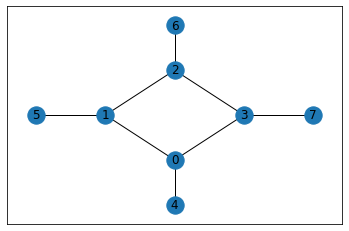

In [163]:
G = nx.Graph()
G.add_edges_from([(0,1), (1,2), (2,3), (3,0), (0,4), (1,5), (2,6), (3,7)])

coordenadas = {0: (2,1), 1: (1,2), 2: (2,3), 3: (3,2), 4: (2,0), 5: (0,2), 6: (2,4), 7: (4,2)}
nx.draw_networkx(G, pos=coordenadas)

$F = V(G)$ y, para todo $v \in V(G)$ tal que $\delta(v) >= 2$, $F_v = V(G) \setminus \{v\}$, son trivialmente fuertes. Con estos ejemplos triviales vemos que un fuerte no necesariamente es minimal, pues $F_v \subset F$, para todo $v \in V(G)$ tal que $\delta(v) >= 2$.

Un fuerte más interesante es $F' = \{0,2,4,6\}$. Notar que es un fuerta ya que $N(F') = \{1,3\}$, $N(1) \cap F' = \{0,2\}$ y $N(3) \cap F' = \{0,2\}$. Además, $F'$ es minimal, pues si tiramos cualquier de sus vértices dejaría de ser un fuerte.

### &#x1f4bb; Actividad 5

Diseñar las siguientes funciones:

* <code>es_fuerte</code> que, dado un grafo $G$ y un conjunto de vértices $F$, retorne True si y sólo si $F$ es un fuerte de $G$. Nuevamente usar conjuntos de Python (set) para representar a $F$.
* <code>minimalizar_fuerte</code> que, dado un grafo $G$ y un conjunto de vértices $F$, retorne un fuerte minimal $F' \subseteq F$ de $G$.

Recordar incluir casos de prueba.

La estructura que tienen los fuertes es extremadamente importante en el estudio de los conjuntos dominantes energéticos. Por ejemplo, en el ejemplo de más arriba se puede notar que cualquier conjunto dominante energético tiene que tener al menos un vértice de $N[F'] = \{0,1,2,3,4,6\}$, ya que de lo contrario los vértices de $F' = \{0,2,4,6\}$ no se podrían monitorear por ninguna de las dos reglas. Y esto vale para cualquier fuerte. Más aún, vale la siguiente caracterización.

**Proposición.** Sea un grafo $G = (V,E)$ y un conjunto de vértices $S \subseteq V$, $S$ es un conjunto dominante energético de $G$ si y solo si $S \cap N[F] \neq \emptyset$ para todo fuerte $F$ de $G$.

Esto motiva la siguiente formulación de PLE para el PDS. Notamos con $\mathcal{F}$ al conjunto de todos los fuertes de $G$.

\begin{align*}
\min & \sum_{v \in V} s_v & \\
\text{s.a.}& \sum_{v \in N[F]} s_v \geq 1 & \forall\ F \in \mathcal{F}. \tag{1}\\
& s \in \{0,1\}^{V}. 
\end{align*}

Como ya hemos observado, no es necesario considerar al conjunto $\mathcal{F}$ de todos los fuertes de $G$, sino que basta con considerar los minimales (pensar cómo probar que la restricción asociada a un fuerte minimal $F$ domina a las asociadas a cualquier fuerte $F'$ que contenga a $F$). Si bien esto puede ayudarnos un poco, desde la teoría de la complejidad computacional, seguimos tratando con un problema difícil. Por un lado, está probado que hay familias de grafos que pueden tener una cantidad exponencial de fuertes minimales. Por el otro, si quisiéramos generarlas a todas, necesitaríamos un algoritmo que encuentre todos los fuertes minimales del grafo, y esto no parece trivial.

Aquí es donde la estrategia **callback de restricciones lazy** puede ser útil. De hecho, y como veremos a continuación, encontrar una restricción (1) violada por un punto entero es un problema muy fácil de resolver, y de hecho lo vamos a resolver.

In [182]:
def buscar_fuertes(G, S):
    M = monitoreados(G, S)
    N = set(G.nodes).difference(M)
    PDS = S.union(N)
    fuertes = []
    candidatos = list(N)
    random.shuffle(candidatos)
    for u in candidatos:
        PDS.remove(u)
        if not es_pds(G, PDS):
            fuerte = set(G.nodes).difference(monitoreados(G, PDS))
            fuertes.append(fuerte)
            PDS.add(u)
    return fuertes

In [183]:
buscar_fuertes(nx.star_graph(5), set())

[{1, 2, 3}]

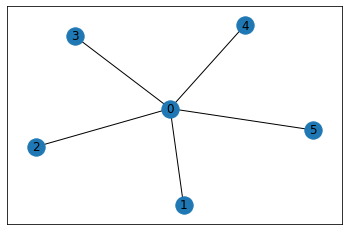

In [184]:
nx.draw_networkx(nx.star_graph(5))

In [185]:
def vecindadFuerte(G, F):
    NF = set(F)
    for v in F:
        for u in G.neighbors(v):
            NF.add(u)
    return NF

In [186]:
from cplex.callbacks import LazyConstraintCallback

class MyLazy(LazyConstraintCallback):

    def __init__(self, env):
        super().__init__(env)
        self.G = None

    def __call__(self):

        S = {v for v in self.G if self.get_values("s_" + str(v)) > 0.5}
        if es_pds(self.G, S):
            return
        
        Fs = buscar_fuertes(self.G, S)
        for F in Fs:
            NF = vecindadFuerte(self.G, F)
            variables = ["s_" + str(v) for v in NF]
            coeficientes = [1] * len(NF)
            self.add([variables, coeficientes], "G", 1) 
        return

In [187]:
def construir_modelo_fort_neighborhood(G):
    modelo = Model(name='PDS-Brimkov') # Inicializamos el modelo     
    S = [modelo.binary_var(name='s_' + str(v)) for v in G]
    modelo.minimize(modelo.sum(S[v] for v in G)) 
    Fs = buscar_fuertes(G, set(G.nodes))
    for F in Fs:
        NF = vecindadFuerte(G, F)
        modelo.add_constraint(S[v] for v in NS >= 1)
    cb = modelo.register_callback(MyLazy)
    cb.G = G
    return modelo

In [188]:
grafo = nx.erdos_renyi_graph(27, 0.25, seed=0)
modelo1 = construir_modelo_fort_neighborhood(grafo)
sol1 = resolver(modelo1)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Legacy callback                                  LD
Lazy constraint(s) or lazy constraint/branch callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling presolve reductions that prevent crushing forms (CPX_PARAM_PREREFORM).
         Disabling repeat represolve because of lazy constraint/incumbent callback.
Tried aggregator 1 time.
Reduced MIP has 0 rows, 27 columns, and 0 nonzeros.
Reduced MIP has 27 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.00 ticks)
Probing time = 0.00 sec. (0.00 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.00 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     